# Timeseries forecasting for weather prediction



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [ ]:
import os
df = pd.read_csv('https://raw.githubusercontent.com/hanhduyenjn/Weather-forecast/master/history.csv')

## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 4/2015 to 3/2022.
It also shows where anomalies are present, which will be addressed during normalization.

DewPointC
HeatIndexC
cloudcover
humidity
precipMM
pressure
tempC
visibility
winddirDegree
windspeedKmph


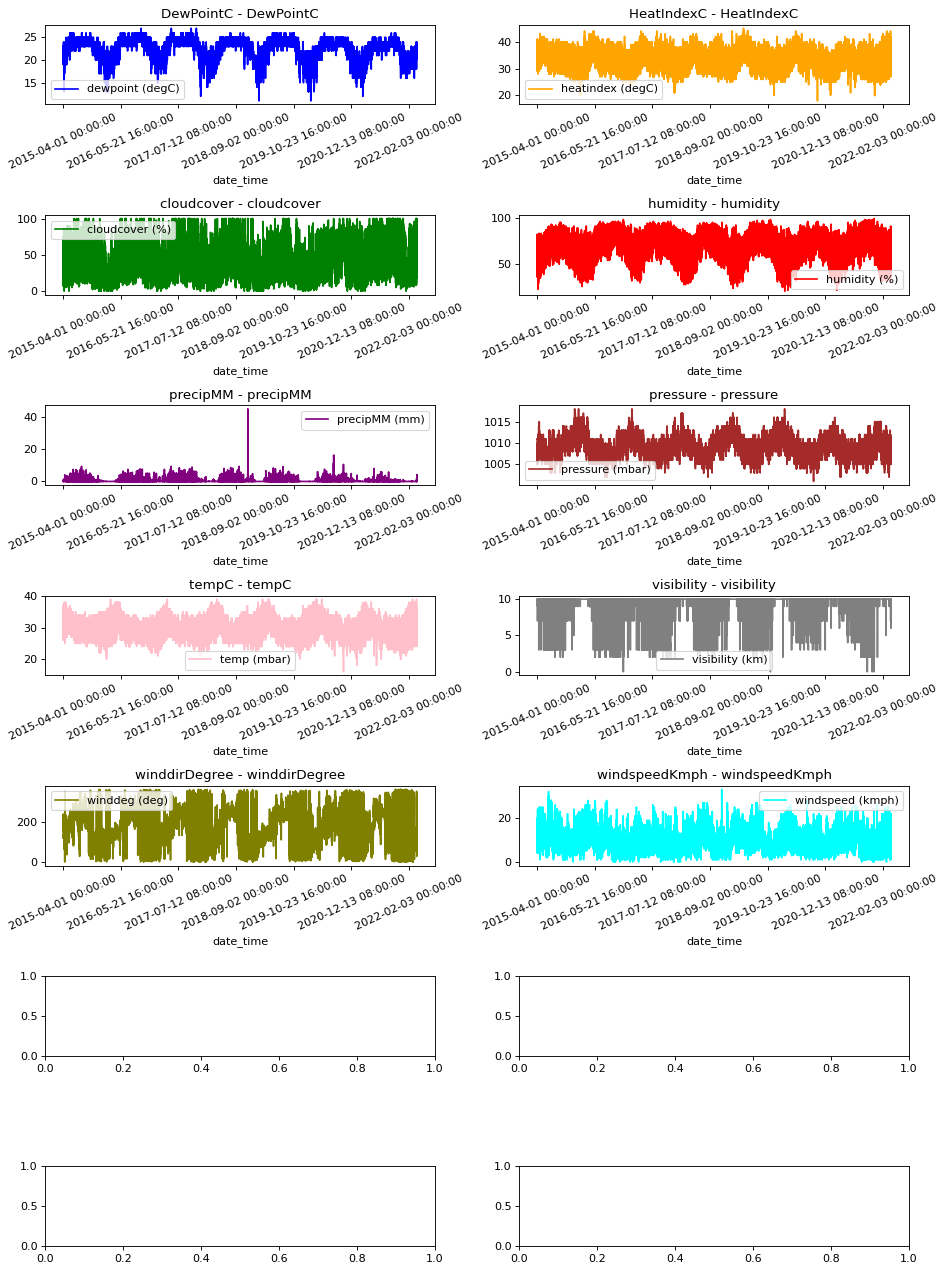

In [ ]:
titles = [
    "DewPointC",
    "HeatIndexC",
    "cloudcover",
    "humidity",
    "precipMM",
    "pressure",
    "tempC",
    "visibility",
    "winddirDegree",
    "windspeedKmph",
    ]

feature_keys = [
    "dewpoint (degC)",
    "heatindex (degC)",
    "cloudcover (%)",
    "humidity (%)",
    "precipMM (mm)",
    "pressure (mbar)",
    "temp (mbar)",
    "visibility (km)",
    "winddeg (deg)",
    "windspeed (kmph)"
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "date_time"
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(12,16), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = titles[i]
        print(key)
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([feature_keys[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

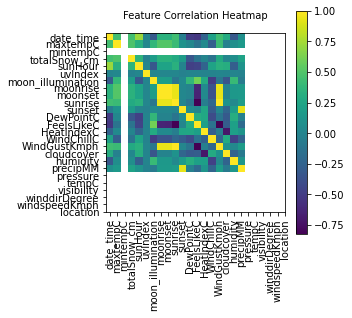

In [ ]:
def show_heatmap(data):
    plt.matshow(data.corr()) #using correlation heatmap
    plt.xticks(range(data.shape[1]), data.columns, fontsize=10, rotation=90) #rotate the font
    plt.gca().xaxis.tick_bottom() #title default for x axis is on top, set it to bottome
    plt.yticks(range(data.shape[1]), data.columns, fontsize=10)

    cb = plt.colorbar() #the color bar at the right
    cb.ax.tick_params(labelsize=10)#show the number
    plt.title("Feature Correlation Heatmap", fontsize=10)
    plt.show()


show_heatmap(df)


## Data Preprocessing

Here we are picking ~60,000 data points for training. Observation is recorded every 1 hour.

We are tracking data from past 120 timestamps. This data will be
used to predict the temperature after 12 timestamps.

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, `split_fraction` can
be changed to alter this percentage.


In [ ]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 48 #history window
future = 1 #value predicted after 1 hour
learning_rate = 0.001
batch_size = 64
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [ ]:
# '''add column rain where the value is 1 if precipMM > 0 else 0'''
df['rain'] = np.where(df['precipMM'] == 0.0, 0, 1)
selected_features = ['tempC','pressure','humidity','rain']
features = df[selected_features]


features.index = df['date_time']
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)

'''add the label column'''
features[3] = df['rain']

features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[3]]

x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[3]]

sequence_length = int(past / step)

# Training dataset

The training dataset labels starts from the 132nd observation (120 + 12).

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 48, 3)
Target shape: (64, 1)


## Validation dataset

The validation dataset must not contain the last 132 rows as we won't have label data for those records, hence 132 must be subtracted from the end of the data.

The validation label dataset must start from 132 after train_split, hence we must add
past + future to label_start.

In [ ]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Training

In [ ]:
# ''''predict value of temp, humid, pressure'''
# inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# lstm_out = keras.layers.LSTM(32)(inputs)
# outputs = keras.layers.Dense(1)(lstm_out)

# model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
# model.summary()

In [ ]:
'''predict rain or not'''
model = tf.keras.Sequential([
    keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss="binary_crossentropy", metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 128)          34816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 80,257
Trainable params: 80,257
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [ ]:
path_checkpoint = "humid_model.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
670/671 [============================>.] - ETA: 0s - loss: 0.5098 - accuracy: 0.7334
Epoch 1: val_loss improved from inf to 0.58416, saving model to humid_model.h5
671/671 [==============================] - 25s 29ms/step - loss: 0.5095 - accuracy: 0.7336 - val_loss: 0.5842 - val_accuracy: 0.7254
Epoch 2/10
671/671 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.7539
Epoch 2: val_loss improved from 0.58416 to 0.52135, saving model to humid_model.h5
671/671 [==============================] - 18s 27ms/step - loss: 0.4866 - accuracy: 0.7539 - val_loss: 0.5213 - val_accuracy: 0.7532
Epoch 3/10
668/671 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.7590
Epoch 3: val_loss improved from 0.52135 to 0.50522, saving model to humid_model.h5
671/671 [==============================] - 18s 27ms/step - loss: 0.4749 - accuracy: 0.7598 - val_loss: 0.5052 - val_accuracy: 0.7573
Epoch 4/10
669/671 [============================>.] - ETA: 0s - loss

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

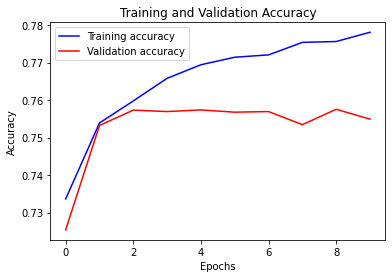

In [ ]:
def visualize_loss(history, title):
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training accuracy")
    plt.plot(epochs, val_loss, "r", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Accuracy")

In [ ]:
'''loop through 10 batch, 64 sample each'''
for x, y in dataset_val.take(10):
      x = tf.reshape(x[0], shape=[1, 48, 3]) #get the first sample of the batch
      print(model.predict(x), y[0].numpy()) #predict then compare with y real of the first sample of the batch

[[0.00273701]] [0]
[[0.00222245]] [0]
[[0.02565884]] [0]
[[0.00608061]] [0]
[[0.00305097]] [0]
[[0.35168508]] [0]
[[0.01352575]] [0]
[[0.00269393]] [0]
[[0.01415086]] [0]
[[0.01269373]] [0]


## Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

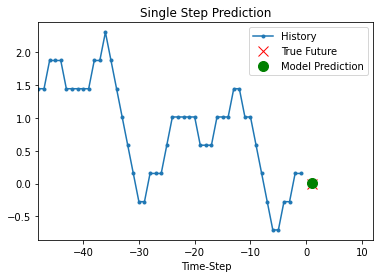

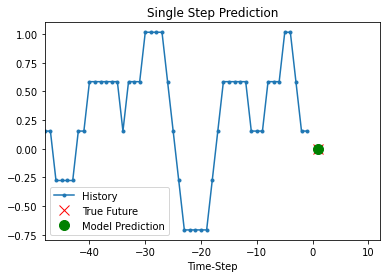

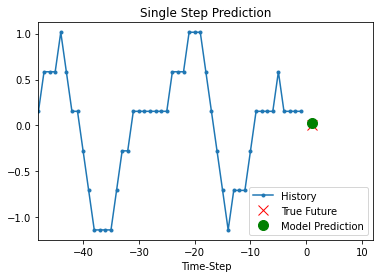

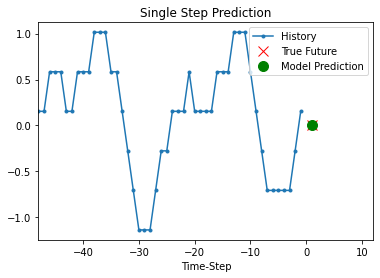

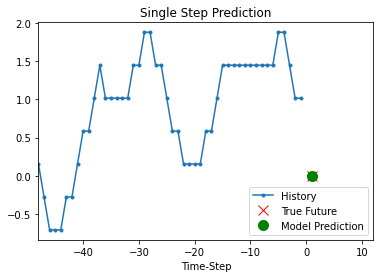

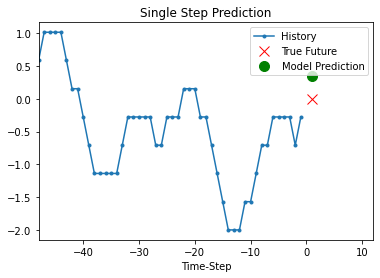

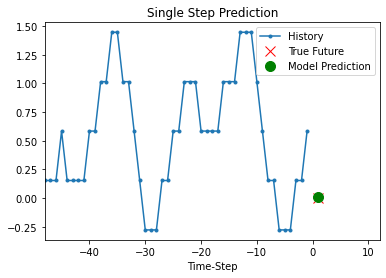

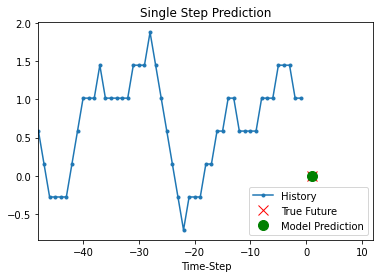

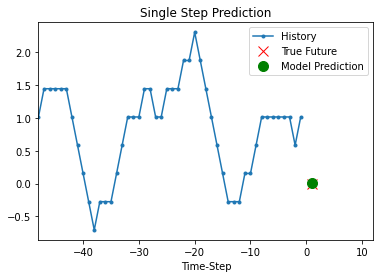

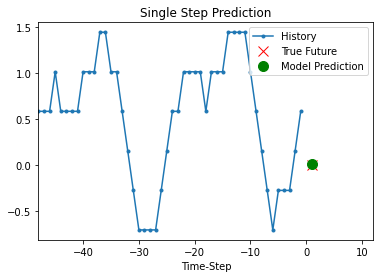

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(10):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

# Mục mới